based on pointsim notebook

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io

sys.path.append("../../src/")
from sarra_py import *

In [2]:
# databse bruelle
from datetime import datetime as dt
observations = pd.read_csv("../../data/observations/2006-2010_database_bvlac_bruelle.csv",sep=";")
observations = observations[observations["village"]=="Ambohimiarina"].reset_index(drop=True)
observations["sowdate"] = observations.apply(lambda x: dt.strptime(x["sowdate"],"%Y-%m-%d").date(), axis=1)
observations["DOY"] = observations.apply(lambda x: x["sowdate"].timetuple().tm_yday, axis=1)
observations

,idfield,cropseason,village,soil,area,tillagesystem,CAyear,sowdate,x24d,glypho,manure,urea,npk,nitrogen,rainsow,rainflow,raincycle,rainyear,yield,DOY
0,F2006070108,Y06_07,Ambohimiarina,lowland,10.0,till,Y0,2006-12-05,Y,N,1666.7,70.0,40.0,36.600,29.6,181.4,1143.3,1288.7,3080.0,339
1,F2006070109,Y06_07,Ambohimiarina,lowland,9.0,till,Y0,2006-12-06,Y,N,3500.0,55.6,33.3,29.239,28.2,210.0,1144.3,1288.7,3166.7,340
2,F2006070110,Y06_07,Ambohimiarina,lowland,13.0,till,Y0,2006-11-27,N,N,1666.7,0.0,230.8,25.388,124.4,179.6,1108.3,1288.7,1038.5,331
3,F2006070111,Y06_07,Ambohimiarina,lowland,50.0,till,Y0,2006-12-27,Y,N,3333.3,30.0,0.0,13.800,62.8,214.7,1089.3,1288.7,1796.0,361
4,F2006070112,Y06_07,Ambohimiarina,hillside,6.5,till,Y0,2006-12-16,N,N,3225.8,0.0,76.9,8.459,6.2,142.0,1132.1,1288.7,4276.9,350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,F2009101108,Y09_10,Ambohimiarina,lowland,0.1,ca,Y1,2009-12-15,N,N,0.0,0.0,0.0,0.000,46.4,138.4,908.6,1105.0,2300.0,349
1580,F2009101110,Y09_10,Ambohimiarina,lowland,0.2,ca,Y1,2009-12-07,N,N,0.0,0.0,0.0,0.000,136.6,2.4,956.2,1105.0,1800.0,341
1581,F2009101111,Y09_10,Ambohimiarina,lowland,0.1,ca,Y1,2009-12-10,N,N,0.0,0.0,0.0,0.000,124.6,34.4,927.4,1105.0,3250.0,344
1582,F2009101112,Y09_10,Ambohimiarina,lowland,0.1,ca,Y1,2009-12-10,N,N,0.0,0.0,0.0,0.000,124.6,34.4,927.4,1105.0,2100.0,344


In [3]:
weather_correspondance = {"Ambohimiarina":"AgERA5_point_madagascar_Ambohimiarina_-18.83_47.13_2006_2010.csv"}
rain_correspondance = {"Ambohimiarina":"TAMSAT_v3.1_point_madagascar_Ambohimiarina_18.83_47.13_2006_2010.csv"}

In [4]:
# sample_observations = observations.groupby("cropseason").sample(n=30, random_state=123).reset_index(drop=True)

In [5]:
num_samples = 150
id_sampling_start = 0

grid_width = 1
grid_height = num_samples
date_start = observations.loc[id_sampling_start:id_sampling_start+num_samples,"sowdate"].values.min()-datetime.timedelta(days=15) # plus petite date en commun entre les dates de semis du set de comparaison
duration = 365

# parameter file names
file_paramVariete = "rice_variety.yaml"
file_paramITK = "rice_itk.yaml" # date de semis à override
file_paramTypeSol = "rice_soil.yaml"

# data exported from SARRA-H
# file_df_weather = "AgERA5_point_madagascar_Ambohimiarina_-18.83_47.13_2006_2010.csv"
# file_df_rain = "TAMSAT_v3.1_point_madagascar_Ambohimiarina_18.83_47.13_2006_2010.csv"
# file_df_ET0 = None
# file_df_irrig = None

# simulated data from SARRA-H for comparison purposes
# file_df_sim = "simu_AG3US20124.txt"




# Read YAML file
with open(os.path.join('../../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)
    
if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

with open(os.path.join('../../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)

# paramITK["DateSemis"] = datetime.datetime.strptime(paramITK["DateSemis"], "%Y-%m-%d").date()
paramITK["DateSemis"] = observations.loc[id_sampling_start:id_sampling_start+num_samples,"sowdate"].values

with open(os.path.join('../../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

In [6]:
def read_and_format_df_weather(file_df_weather, file_df_rain, file_df_irrig, file_df_ET0):
    # loading weather data and rain data exported from SARRA-H
    # df weather
    # df_weather = pd.read_csv(os.path.join('../../data/weather/',file_df_weather), sep="\t", decimal=",", skiprows=1)
    df_weather = pd.read_csv(os.path.join('../../data/weather/',file_df_weather), sep=",", decimal=".")

    # adaptation AgERA5
    #df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
    df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour_SARRA_H"], "%d/%m/%Y").date(), axis=1)
    df_weather = df_weather[(df_weather["Jour"] >= date_start) & (df_weather["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
    df_weather["TMoy"] = ((df_weather["TMin"] + df_weather["TMax"]) / 2) 

    # df rain
    #df_rain = pd.read_csv(os.path.join('../../data/rain/',file_df_rain), sep="\t", decimal=",", skiprows=1)
    df_rain = pd.read_csv(os.path.join('../../data/rain/',file_df_rain), sep=",", decimal=".")
    # adaptation TAMSAT
    # df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
    df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["time"], "%Y-%m-%d").date(), axis=1)

    df_rain = df_rain[(df_rain["Jour"] >= date_start) & (df_rain["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
    df_rain["RAIN"] = df_rain["rfe_filled"]
    #df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
    df_weather = df_weather.merge(df_rain, right_on=["Jour"], left_on=["Jour"])

    df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

    # df ET0
    if file_df_ET0 == None :
        df_weather["ET0"] = df_weather["ET0_PM"] 

    else:
        df_ET0 = pd.read_csv(os.path.join('../data/et0/',file_df_ET0), sep="\t", decimal=",", skiprows=1)
        df_ET0["Jour"] = df_ET0.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
        df_ET0 = df_ET0[(df_ET0["Jour"] >= date_start) & (df_ET0["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
        df_weather = df_weather.merge(df_ET0[["Jour","Eto"]], left_on="Jour", right_on="Jour", how="outer")
        df_weather["ET0"] = df_weather["Eto"] # pour code qui appelle Eto/ET0

    # df irrig
    if file_df_irrig == None :
        df_weather["Irrigation"] = 0

    else:
        df_irrig = pd.read_csv(os.path.join('../data/irrig/',file_df_irrig), sep="\t", decimal=",", skiprows=1)
        df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
        df_irrig = df_irrig[(df_irrig["Jour"] >= date_start) & (df_irrig["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
        df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
        df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

    return df_weather

df_weather = read_and_format_df_weather(weather_correspondance["Ambohimiarina"], rain_correspondance["Ambohimiarina"], file_df_irrig=None, file_df_ET0=None)
df_weather

,Unnamed: 0,TMin,Point,Jour,TMax,IRRAD,Vap,Vt,TEMP,es,...,lat,lon,ELEV,ET0_PM,time,rfe,rfe_filled,RAIN,ET0,Irrigation
0,303,14.563721,Ambohimiarina,2006-10-31,28.435883,25.464563,14.437172,4.802899,21.499802,25.203695,...,-18.83,47.13,1237,6.721885,2006-10-31,0.0,0.0,0.0,6.721885,0
1,304,14.481354,Ambohimiarina,2006-11-01,29.601807,28.752245,13.173404,4.001131,22.041581,25.057716,...,-18.83,47.13,1237,7.335201,2006-11-01,0.0,0.0,0.0,7.335201,0
2,305,14.041718,Ambohimiarina,2006-11-02,30.826904,27.064758,13.032003,2.864932,22.434311,26.547413,...,-18.83,47.13,1237,6.816349,2006-11-02,0.0,0.0,0.0,6.816349,0
3,306,14.676544,Ambohimiarina,2006-11-03,30.882477,28.671282,12.410324,1.992718,22.779511,27.077053,...,-18.83,47.13,1237,6.540267,2006-11-03,0.0,0.0,0.0,6.540267,0
4,307,14.346252,Ambohimiarina,2006-11-04,32.108400,29.411758,12.778531,2.520686,23.227326,27.431015,...,-18.83,47.13,1237,7.173297,2006-11-04,0.0,0.0,0.0,7.173297,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,663,14.621521,Ambohimiarina,2007-10-26,25.565400,22.947060,15.078962,3.721561,20.093460,22.740658,...,-18.83,47.13,1237,5.246431,2007-10-26,0.0,0.0,0.0,5.246431,0
361,664,13.954742,Ambohimiarina,2007-10-27,23.220062,22.274063,13.556574,5.209398,18.587402,20.387825,...,-18.83,47.13,1237,5.207123,2007-10-27,0.0,0.0,0.0,5.207123,0
362,665,12.786255,Ambohimiarina,2007-10-28,23.969543,23.369656,12.879024,3.659109,18.377899,19.753332,...,-18.83,47.13,1237,5.176367,2007-10-28,0.0,0.0,0.0,5.176367,0
363,666,12.942963,Ambohimiarina,2007-10-29,24.938690,28.283768,12.560553,3.165557,18.940827,20.776770,...,-18.83,47.13,1237,5.834955,2007-10-29,0.0,0.0,0.0,5.834955,0


In [7]:
df_weather_collection = {}
for sample in tqdm(range(num_samples)):
    location = observations.loc[id_sampling_start+sample,"village"]
    df_weather_collection[sample] = read_and_format_df_weather(weather_correspondance[location], rain_correspondance[location], file_df_irrig=None, file_df_ET0=None)

100%|██████████| 150/150 [00:11<00:00, 13.04it/s]


In [8]:
def InitSup2_alt(data, grid_width, grid_height, duration, df_weather):
    data["tpMoy"] = np.concatenate([df_weather_collection[df_weather_id]["TEMP"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rain"] = np.concatenate([df_weather_collection[df_weather_id]["RAIN"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["ET0"] = np.concatenate([df_weather_collection[df_weather_id]["ET0"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rg"] = np.concatenate([df_weather_collection[df_weather_id]["IRRAD"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    return data

# Run

In [9]:
import warnings
warnings.filterwarnings("ignore")

data_run = {}

data_run = InitPlotMc(data_run, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
data_run = InitiationCulture(data_run, grid_width, grid_height, duration, paramVariete)
data_run = InitSup(data_run, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK) # penser à override l'irrigation
# data_run = InitSup2(data_run, grid_width, grid_height, duration, df_weather)
data_run = InitSup2_alt(data_run, grid_width, grid_height, duration, df_weather)
data_run = EvalPar(data_run)

for j in tqdm(range(duration)):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    # if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][0]:
    #     print("do nothing")
    #     data_run = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
    #     data_run = EvalDegresJourSarrahV3(j, data_run, paramVariete) # ***phenologie*** et exmodules ### trad OK

    #procédure pour prendre en compte une date de semis différente par sample/pixel vertical

    data_run_local = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete).copy() # ***phenologie*** et exmodules ### trad OK
    data_run_local = EvalDegresJourSarrahV3(j, data_run_local, paramVariete) # ***phenologie*** et exmodules ### trad OK

    for sample in range(num_samples):
        if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][sample]:
            for variable in data_run_local :
                try:
                    data_run[variable][:,sample,j:] = data_run_local[variable][0,sample,j:].copy()
                    data_run[variable][:,sample,j:] = data_run_local[variable][:,sample,j:].copy()
                except:
                    pass

    #bilan hydrique
    data_run = EvalIrrigPhase(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = PluieIrrig(j, data_run) # ***bileau***, exmodules 2 ###trad OK
    data_run = RempliMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = EvalRunOff(j, data_run, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data_run = EvolRurCstr2(j, data_run, paramITK) # ***bileau*** ##trad OK
    data_run = rempliRes(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data_run = EvalFESW(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data_run = EvalKceMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data_run = DemandeSol(j, data_run) # ***bileau***, exmodules 1 & 2 ### trad OK
    data_run = EvapMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = EvapRuSurf(j, data_run) # ***bileau***, exmodules 1 & 2 ###trad OK
    data_run = EvalFTSW(j, data_run) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data_run = EvolKcpKcIni(j, data_run, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data_run = DemandePlante(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data_run = EvalKcTot(j, data_run) # ***bileau***, exmodules 1 & 2 ## trad O
    data_run = CstrPFactor(j, data_run, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data_run = EvalTranspi(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data_run = ConsoResSep(j, data_run) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data_run = EvalVitesseRacSarraV3(j, data_run, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data_run = EvalLtr(j, data_run, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data_run = EvalConversion(j, data_run, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data_run = BiomDensOptSarV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data_run = EvalAssimSarrahV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data_run = EvalRespMaintSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data_run = EvolBiomTotSarrahV4(j, data_run, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data_run = EvalRdtPotRespSarV42(j, data_run, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data_run = EvolBiomAeroSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data_run = EvalReallocationSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data_run = EvalBiomasseRacinaire(j, data_run) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data_run = EvalFeuilleTigeSarrahV4(j, data_run, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data_run = EvalBiomasseVegetati(j, data_run) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data_run = EvalSlaSarrahV3(j, data_run, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data_run = EvolLAIPhases(j, data_run) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data_run = EvolDayRdtSarraV3(j, data_run) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data_run = PhotoperSarrahV3(j, data_run, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data_run = MortaliteSarraV3(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data_run = BiomDensiteSarraV42(j, data_run, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data_run = BiomMcUBTSV3(j, data_run, paramITK) # ***bilancarbonsarra***, exmodules 2
    data_run = MAJBiomMcSV3(data_run) # ***bilancarbonsarra***, exmodules 2

df_comparison = pd.DataFrame({"observed_yield":observations.loc[id_sampling_start:id_sampling_start+num_samples-1, "yield"], "simulated_yield":[data_run["rdt"][0,i,-1] for i in range(num_samples)]})
corrcoeff = df_comparison.corr().iloc[0,1]
print("corrcoeff=",corrcoeff)

100%|██████████| 365/365 [00:19<00:00, 19.06it/s]

corrcoeff= 0.18843142262432516


In [10]:
df_comparison = pd.DataFrame({"observed_yield":observations.loc[id_sampling_start:id_sampling_start+num_samples-1, "yield"], "simulated_yield":[data_run["rdt"][0,i,364] for i in range(num_samples)]})

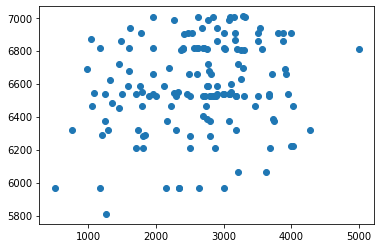

In [11]:
plt.scatter(df_comparison["observed_yield"], df_comparison["simulated_yield"])

# essai optim

In [12]:
import warnings
warnings.filterwarnings("ignore")

def run(SDJRPR):

    data_run = {}

    data_run = InitPlotMc(data_run, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
    data_run = InitiationCulture(data_run, grid_width, grid_height, duration, paramVariete)
    data_run = InitSup(data_run, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK) # penser à override l'irrigation
    # data_run = InitSup2(data_run, grid_width, grid_height, duration, df_weather)
    data_run = InitSup2_alt(data_run, grid_width, grid_height, duration, df_weather)
    data_run = EvalPar(data_run)

    paramVariete["SDJRPR"] = SDJRPR

    for j in tqdm(range(duration)):
        # on reporte en commentaire les fichiers source dans lesquelles se trouvent
        # les procédures concernées. no note ***entre étoiles*** les procédures
        # retenues pour cette traduction python

        # if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][0]:
        #     print("do nothing")
        #     data_run = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        #     data_run = EvalDegresJourSarrahV3(j, data_run, paramVariete) # ***phenologie*** et exmodules ### trad OK

        #procédure pour prendre en compte une date de semis différente par sample/pixel vertical

        data_run_local = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete).copy() # ***phenologie*** et exmodules ### trad OK
        data_run_local = EvalDegresJourSarrahV3(j, data_run_local, paramVariete) # ***phenologie*** et exmodules ### trad OK

        for sample in range(num_samples):
            if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][sample]:
                for variable in data_run_local :
                    try:
                        data_run[variable][:,sample,j:] = data_run_local[variable][0,sample,j:].copy()
                        data_run[variable][:,sample,j:] = data_run_local[variable][:,sample,j:].copy()
                    except:
                        pass

        #bilan hydrique
        data_run = EvalIrrigPhase(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = PluieIrrig(j, data_run) # ***bileau***, exmodules 2 ###trad OK
        data_run = RempliMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = EvalRunOff(j, data_run, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
        data_run = EvolRurCstr2(j, data_run, paramITK) # ***bileau*** ##trad OK
        data_run = rempliRes(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
        data_run = EvalFESW(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
        data_run = EvalKceMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ###trad OK
        data_run = DemandeSol(j, data_run) # ***bileau***, exmodules 1 & 2 ### trad OK
        data_run = EvapMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = EvapRuSurf(j, data_run) # ***bileau***, exmodules 1 & 2 ###trad OK
        data_run = EvalFTSW(j, data_run) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
        data_run = EvolKcpKcIni(j, data_run, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
        data_run = DemandePlante(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
        data_run = EvalKcTot(j, data_run) # ***bileau***, exmodules 1 & 2 ## trad O
        data_run = CstrPFactor(j, data_run, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
        data_run = EvalTranspi(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
        data_run = ConsoResSep(j, data_run) # ***bileau***; exmodules 1 & 2 # trad O
        # phenologie
        data_run = EvalVitesseRacSarraV3(j, data_run, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
        
        # bilan carbone
        data_run = EvalLtr(j, data_run, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
        data_run = EvalConversion(j, data_run, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
        data_run = BiomDensOptSarV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data_run = EvalAssimSarrahV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data_run = EvalRespMaintSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data_run = EvolBiomTotSarrahV4(j, data_run, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
        data_run = EvalRdtPotRespSarV42(j, data_run, paramVariete) # ***bilancarbonsarra*** ###trad OK
        data_run = EvolBiomAeroSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data_run = EvalReallocationSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data_run = EvalBiomasseRacinaire(j, data_run) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
        data_run = EvalFeuilleTigeSarrahV4(j, data_run, paramVariete) # ***bilancarbonesarra*** ### trad OK
        data_run = EvalBiomasseVegetati(j, data_run) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data_run = EvalSlaSarrahV3(j, data_run, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
        data_run = EvolLAIPhases(j, data_run) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data_run = EvolDayRdtSarraV3(j, data_run) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
        #phenologie
        data_run = PhotoperSarrahV3(j, data_run, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
        
        # bilan carbone
        data_run = MortaliteSarraV3(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data_run = BiomDensiteSarraV42(j, data_run, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
        data_run = BiomMcUBTSV3(j, data_run, paramITK) # ***bilancarbonsarra***, exmodules 2
        data_run = MAJBiomMcSV3(data_run) # ***bilancarbonsarra***, exmodules 2

    df_comparison = pd.DataFrame({"observed_yield":observations.loc[id_sampling_start:id_sampling_start+num_samples-1, "yield"], "simulated_yield":[data_run["rdt"][0,i,-1] for i in range(num_samples)]})
    corrcoeff = df_comparison.corr().iloc[0,1]
    print("corrcoeff=",corrcoeff)

    return -corrcoeff

In [13]:
from hyperopt import fmin, tpe, hp
best = fmin(fn=run,
    space=hp.uniform('SDJRPR', 200, 600),
    algo=tpe.suggest,
    max_evals=30)
print(best)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

100%|##########| 365/365 [00:16<00:00, 22.79it/s]


corrcoeff=                                            
0.1935686995283353                                    
  3%|▎         | 1/30 [00:16<07:45, 16.04s/trial, best loss: -0.1935686995283353]

100%|##########| 365/365 [00:18<00:00, 19.88it/s]


corrcoeff=                                                                       
0.23100615588898185                                                              
  7%|▋         | 2/30 [00:34<08:07, 17.42s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:18<00:00, 19.55it/s]


corrcoeff=                                                                        
0.1428367300407569                                                                
 10%|█         | 3/30 [00:53<08:05, 18.00s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 18.09it/s]


corrcoeff=                                                                        
0.1879321885374451                                                                
 13%|█▎        | 4/30 [01:13<08:10, 18.87s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 18.03it/s]


corrcoeff=                                                                        
0.1548664115733396                                                                
 17%|█▋        | 5/30 [01:33<08:04, 19.38s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.89it/s]


corrcoeff=                                                                        
0.15650338781751552                                                               
 20%|██        | 6/30 [01:54<07:53, 19.73s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:22<00:00, 16.21it/s]


corrcoeff=                                                                        
0.18809445056613006                                                               
 23%|██▎       | 7/30 [02:16<07:54, 20.65s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:19<00:00, 18.61it/s]


corrcoeff=                                                                        
0.13314803969336003                                                               
 27%|██▋       | 8/30 [02:36<07:27, 20.33s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:19<00:00, 18.96it/s]


corrcoeff=                                                                        
0.12032654457391688                                                               
 30%|███       | 9/30 [02:55<06:59, 20.00s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 18.20it/s]


corrcoeff=                                                                        
0.19066567732874157                                                               
 33%|███▎      | 10/30 [03:15<06:40, 20.02s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 18.11it/s]


corrcoeff=                                                                         
0.18647494378060964                                                                
 37%|███▋      | 11/30 [03:35<06:21, 20.07s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 18.03it/s]


corrcoeff=                                                                         
0.18702869092709226                                                                
 40%|████      | 12/30 [03:55<06:02, 20.13s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.88it/s]


corrcoeff=                                                                         
0.19754824757772846                                                                
 43%|████▎     | 13/30 [04:16<05:43, 20.22s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:19<00:00, 18.27it/s]


corrcoeff=                                                                         
0.15787858931067064                                                                
 47%|████▋     | 14/30 [04:36<05:22, 20.16s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:19<00:00, 18.26it/s]


corrcoeff=                                                                         
0.20731214609068688                                                                
 50%|█████     | 15/30 [04:56<05:01, 20.11s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.90it/s]


corrcoeff=                                                                         
0.14554064296148886                                                                
 53%|█████▎    | 16/30 [05:16<04:42, 20.20s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.98it/s]


corrcoeff=                                                                         
0.13723172593440547                                                                
 57%|█████▋    | 17/30 [05:37<04:23, 20.24s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:21<00:00, 17.35it/s]


corrcoeff=                                                                         
0.17252832914322447                                                                
 60%|██████    | 18/30 [05:58<04:05, 20.49s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.85it/s]


corrcoeff=                                                                         
0.2042674210434336                                                                 
 63%|██████▎   | 19/30 [06:18<03:45, 20.48s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.43it/s]


corrcoeff=                                                                         
0.12059638052319419                                                                
 67%|██████▋   | 20/30 [06:39<03:26, 20.63s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.71it/s]


corrcoeff=                                                                         
0.1565988619580179                                                                 
 70%|███████   | 21/30 [07:00<03:05, 20.63s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.58it/s]


corrcoeff=                                                                         
0.1170709842959718                                                                 
 73%|███████▎  | 22/30 [07:21<02:45, 20.68s/trial, best loss: -0.23100615588898185]

100%|##########| 365/365 [00:20<00:00, 17.92it/s]


corrcoeff=                                                                         
0.2708793174997453                                                                 
 77%|███████▋  | 23/30 [07:41<02:24, 20.59s/trial, best loss: -0.2708793174997453] 

100%|##########| 365/365 [00:20<00:00, 17.65it/s]


corrcoeff=                                                                        
0.17060394088119318                                                               
 80%|████████  | 24/30 [08:02<02:03, 20.63s/trial, best loss: -0.2708793174997453]

100%|##########| 365/365 [00:21<00:00, 16.98it/s]


corrcoeff=                                                                        
0.17163059014295678                                                               
 83%|████████▎ | 25/30 [08:23<01:44, 20.90s/trial, best loss: -0.2708793174997453]

100%|##########| 365/365 [00:20<00:00, 17.68it/s]


corrcoeff=                                                                        
0.13095967259157446                                                               
 87%|████████▋ | 26/30 [08:44<01:23, 20.83s/trial, best loss: -0.2708793174997453]

100%|##########| 365/365 [00:20<00:00, 17.55it/s]


corrcoeff=                                                                        
0.17647634635408282                                                               
 90%|█████████ | 27/30 [09:05<01:02, 20.83s/trial, best loss: -0.2708793174997453]

100%|##########| 365/365 [00:21<00:00, 17.07it/s]


corrcoeff=                                                                        
0.15609775671431256                                                               
 93%|█████████▎| 28/30 [09:26<00:42, 21.00s/trial, best loss: -0.2708793174997453]

100%|##########| 365/365 [00:21<00:00, 17.37it/s]


corrcoeff=                                                                        
0.12281520291248844                                                               
 97%|█████████▋| 29/30 [09:47<00:21, 21.01s/trial, best loss: -0.2708793174997453]

100%|##########| 365/365 [00:20<00:00, 17.54it/s]


corrcoeff=                                                                        
0.13274970173743644                                                               
100%|██████████| 30/30 [10:08<00:00, 20.28s/trial, best loss: -0.2708793174997453]
{'SDJRPR': 445.4711505237362}


In [18]:
def run_neg(SDJRPR):
    return -run(SDJRPR)

In [19]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'SDJRPR': (200, 600)}

optimizer = BayesianOptimization(
    f=run_neg,
    pbounds=pbounds,
    random_state=1,
)

In [20]:
optimizer.maximize(
    init_points=10,
    n_iter=20,
)

|   iter    |  target   |  SDJRPR   |
-------------------------------------


100%|██████████| 365/365 [00:17<00:00, 20.88it/s]


corrcoeff= 0.1575868316369709
| 1         | 0.1576    | 366.8     |


100%|██████████| 365/365 [00:17<00:00, 20.40it/s]


corrcoeff= 0.1975487479586888
| 2         | 0.1975    | 488.1     |


100%|██████████| 365/365 [00:20<00:00, 17.96it/s]


corrcoeff= 0.14005753574665109
| 3         | 0.1401    | 200.0     |


100%|██████████| 365/365 [00:22<00:00, 16.08it/s]


corrcoeff= 0.13543782467171236
| 4         | 0.1354    | 320.9     |


 47%|████▋     | 170/365 [00:09<00:11, 17.18it/s]